# DSI19 Project 2 - Model training and processing notebook   
 
----

## Table of Contents

* [1. Model Preparation](#chapter1)
    * [1.1 Creating the features matrix `X` and target variable `y`](#section_1_1)
    * [1.2 Train/test split](#section_1_2)
    * [1.3 Scaling the data](#section_1_3)
    * [1.4 Instantiating the models](#section_1_4)
* [2. Model Evaluation](#chapter2)
    * [2.1 Obtaining `cross_val_score` based on `x_train`](#section_2_1)
    * [2.2 Obtaining `cross_val_score` based on `x_test`](#section_2_2)
    * [2.3 Conclusion](#section_2_3)
* [3. Initial Model Fitting and Evaluation](#chapter3)
    * [3.1 Fitting model on full data set](#section_3_1)
    * [3.2 Predictions vs actuals](#section_3_2)
    * [3.3 Residuals](#section_3_3)
    * [3.4 Additional outliers evaluation](#section_3_4)
    * [3.4 Coefficients](#section_3_5)
* [4. Further Model Refinement](#chapter4)
    * [4.1 Defining refined selection of features as `X_ref` and scaling the data](#section_4_1)
    * [4.2 Refined model fitting](#section_4_2)
    * [4.3 Actuals vs Prediction based on refined model](#section_4_3)
    * [4.4 Residuals for refined model](#section_4_4)
    * [4.5 Evaluation of results](#section_4_5)
* [5. Test Data Prediction](#chapter5)
    * [5.1 Original features lasso model](#section_5_1)
    * [5.2 Refined features lasso model](#section_5_2)
    * [5.3 Kaggle results](#section_5_3)
* [6. Conclusion](#chapter6)
* [7. Limitations](#chapter7)
    * [7.1 Long term prediction](#section_7_1)
    * [7.2 Scope](#section_7_2)
    * [7.3 Location score](#section_7_3)


In [1]:
# Import python modules
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

%config InLineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Read in data set
train_df = pd.read_csv('../datasets/train_model.csv').drop('Unnamed: 0',axis=1)
test_df = pd.read_csv('../datasets/test_model.csv').drop('Unnamed: 0',axis=1)

## 1. Model Preparation <a class="anchor" id="chapter1"></a>
---

### 1.1 Creating the features matrix `X` and target variable `y` <a class="anchor" id="section_1_1"></a>

Every numerical column in the `train_df` will initially be used as a feature. All non-numeric columns were previously engineered into numeric columns using various methods in previous notebooks.  
The target variable is `SalePrice`.

In [3]:
features = list(train_df.columns.drop(['SalePrice','Id']))
X = train_df[features]
y = train_df['SalePrice']

### 1.2 Train/test split <a class="anchor" id="section_1_2"></a>
The training data will be split into a model set and holdout set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True)

### 1.3 Scaling the data <a class="anchor" id="section_1_2"></a>
As Lasso and Ridge models will be used, the data needs to be scaled using `StandardScalar`.

In [5]:
# Instantiate scalar
ss = StandardScaler()

# Fit scalar to training set
ss.fit(X_train)

# Transform training set and testing set
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

### 1.4 Instantiating the models <a class="anchor" id="section_1_4"></a>
Models used will be:
- `LinearRegression`
- `LassoCV`
- `RidgeCV`
- `ElasticNetCV`

Instances of all 4 models will be created.

In [6]:
# Instantiating instances of all 4 models
lr = LinearRegression()
lasso = LassoCV(n_alphas = 200, max_iter=2000, n_jobs=-1)
ridge = RidgeCV(alphas = np.linspace(.001,1,100))
enet = ElasticNetCV(l1_ratio=np.linspace(.001,1,100), n_alphas=200, n_jobs=-1)

## 2. Model Evaluation <a class="anchor" id="chapter2"></a>
---

`cross_val_score` will be used to evaluate all 4 models.

### 2.1 Obtaining `cross_val_score` based on `x_train` <a class="anchor" id="section_2_1"></a>

In [7]:
# Obtain cross_val_score of X_train for each model based on 10 folds
model_dict = {'lr':lr,'lasso':lasso,'ridge':ridge,'enet':enet}

cv_score_dict = {}
for key,value in model_dict.items():
    cv_score_dict[key] = cross_val_score(value, X_train_ss, y_train, cv = 10).mean() *100
    
cv_train_df = pd.DataFrame(cv_score_dict.values(),index=cv_score_dict.keys(),columns=['R2_train'])
display(cv_train_df.T)

,lr,lasso,ridge,enet
R2_train,89.209564,89.559746,89.218119,89.559746


The cross validation scores for 10 folds reveals that the `lasso` model is the strongest. Given that the `enet` score is exactly the same as the `lasso`, we can infer that the alpha is 1, meaning that enet has evaluated the optimal mix of `lasso` and `ridge1` to be 100% `lasso`.

### 2.2 Obtaining `cross_val_score` based on `x_test` <a class="anchor" id="section_2_2"></a>

In [8]:
# Obtain cross_val_score of X_test for each model based on 10 folds
model_dict = {'lr':lr,'lasso':lasso,'ridge':ridge,'enet':enet}

cv_score_dict = {}
for key,value in model_dict.items():
    cv_score_dict[key] = cross_val_score(value, X_test_ss, y_test, cv = 10).mean() *100
    
cv_test_df = pd.DataFrame(cv_score_dict.values(),index=cv_score_dict.keys(),columns=['R2_test'])
display(cv_test_df.T)

,lr,lasso,ridge,enet
R2_test,-2.706548e+25,87.282461,84.830397,87.282461


The cross validation scores based on the `X_test` showed similar scores to the `X_train` set.

### 2.3 Conclusion <a class="anchor" id="section_2_3"></a>

In [9]:
# Observing differences between R2 scores between X_train and X_test
cv_eval_df = cv_train_df.merge(cv_test_df,left_index=True,right_index=True)
cv_eval_df['train_test_diff'] = cv_eval_df['R2_train'] - cv_eval_df['R2_test']
display(cv_eval_df)

,R2_train,R2_test,train_test_diff
lr,89.209564,-2.706548e+25,2.706548e+25
lasso,89.559746,8.728246e+01,2.277284e+00
ridge,89.218119,8.483040e+01,4.387722e+00
enet,89.559746,8.728246e+01,2.277284e+00


- Model with best R2 score is consistently `LassoCV`
- Model with the smallest difference between the train set and test set (disregarding standard `Linear Regression` due to very low R2 score) is also `LassoCV`
- Scores from `Elastic Net` further support this as the scores are exactly identical to `LassoCV`, showing that `Elastic Net` is using a mix of 100% `Lasso`
- Scores from `Lasso` imply that is has the lowest Bias (due to highest R2 score) and Variance (due to smallest difference between train and test R2 score)

**Conclusion**  
`LassoCV` will be the model used.

## 3. Initial Model Fitting and Evaluation <a class="anchor" id="chapter3"></a>
---
Given the model evaluation results, `LassoCV` will be used as the model going forward. The entire `X` dataset will now be scaled and fitted.

### 3.1 Fitting model on full data set <a class="anchor" id="section_3_1"></a>

In [11]:
# Fit scalar to entire X dataset and transform
ss.fit(X)
Xss = ss.transform(X)

# Fit Lasso model
lasso.fit(Xss,y)
lasso_fit_score = lasso.score(Xss,y)
print(f"The Lasso score is {round(lasso_fit_score,4)}.")

The Lasso score is 0.9008.


### 3.2 Predictions vs actuals <a class="anchor" id="section_3_2"></a>

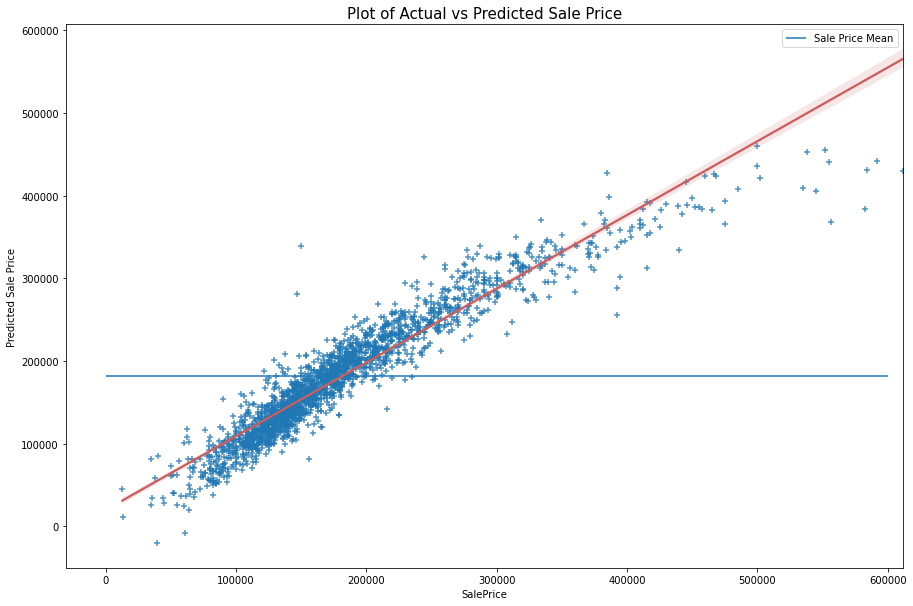

In [31]:
# Obtain prediction values
pred = lasso.predict(Xss)
# Plot predictions vs actual values
plt.figure(figsize=(15,10))
plt.title("Plot of Actual vs Predicted Sale Price", size = 15)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.hlines(y=train_df['SalePrice'].mean(),xmin=0,xmax=600000,label = 'Sale Price Mean')
sns.regplot(x = y, y = pred,marker='+',line_kws={'color':'indianred'})
plt.legend()
plt.savefig("../images/lasso_pred_1.png");

Plotting the actual target vs the predicted targe values, we see a relatively good linear relationship between the 2, reinforcing the high Lasso score of the model obtained earlier.

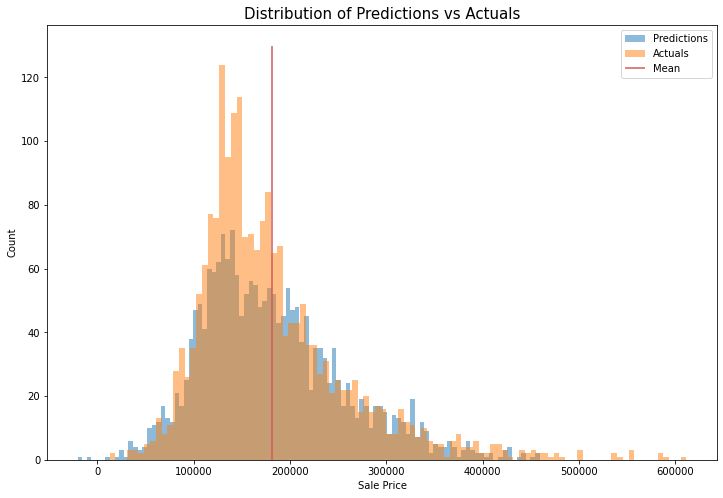

In [33]:
# Histogram of predictions vs actuals
plt.figure(figsize=(12,8))
plt.title("Distribution of Predictions vs Actuals",size=15)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.hist(pred,bins=100,alpha=0.5,label="Predictions")
plt.hist(y,bins=100,alpha=0.5,label="Actuals")
plt.vlines(y.mean(),ymin=0,ymax=130,color='indianred',label="Mean")
plt.legend();

From the distribution, we see that our predictions do generally quite well as the two distributions largely overlap.

### 3.3 Residuals <a class="anchor" id="section_3_3"></a>

The RMSE for the model is 24970.5444.


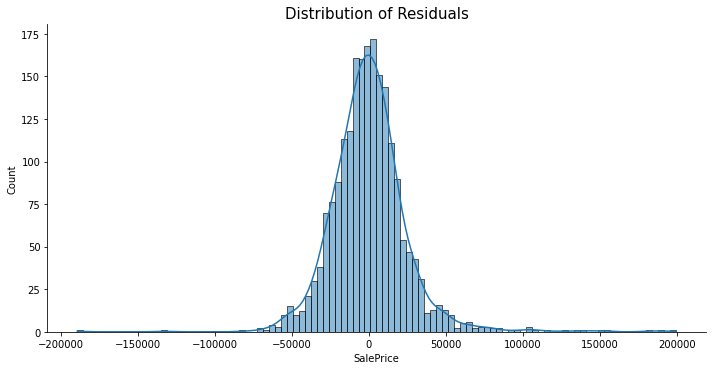

In [101]:
# Obtaining residuals
residuals = y - pred
RMSE = np.sqrt(mean_squared_error(y,pred))
print(f"The RMSE for the model is {round(RMSE,4)}.")

# Plot distribution of residuals
sns.displot(x=residuals,bins=100,kde=True,aspect=2)
plt.title("Distribution of Residuals",size=15)
plt.savefig("../images/lasso_residuals_1.png");

Residuals are normally distributed with mean 0, implying that the model selected and assumptions used are valid. However, it is also observed that tails are very long and may suggest the existence of additional outliers.

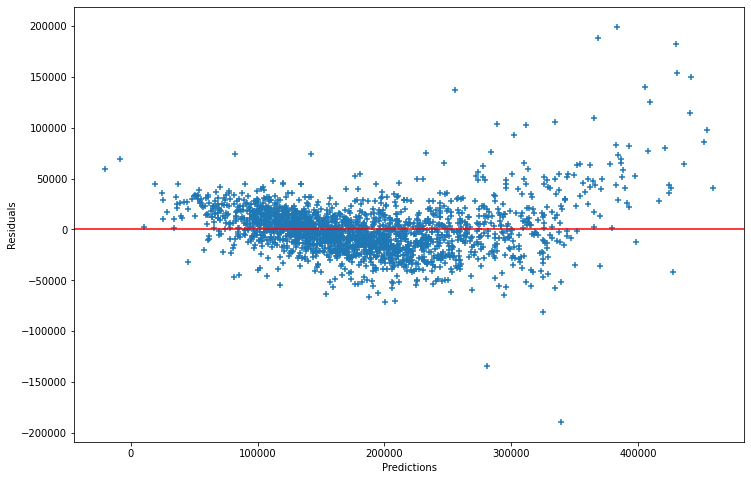

In [65]:
# Plot predictions against residuals to identify outlying points
plt.figure(figsize=(12,8))
plt.axhline(0, c='r')
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.scatter(x=pred,y=residuals,marker="+");

In [66]:
# Observe residuals
residuals_df = pd.DataFrame({'id':train_df['Id'], 'residuals':residuals}).sort_values(by='residuals',ascending=False)
print("Top 5 positive residuals")
display(residuals_df.head())
print("Top 5 negative residuals")
display(residuals_df.tail())

Top 5 positive residuals


,id,residuals
1795,434,199354.188812
151,2333,188430.051514
1670,45,182002.628194
1691,2451,154073.721564
1962,1638,149627.806901


Top 5 negative residuals


,id,residuals
1655,2562,-70265.135560
1694,1916,-71829.453128
378,1614,-81058.062189
348,1783,-134114.227022
125,1183,-189433.717295


It is observed that there are 4 data points with particularly high residuals of > 180,000.

### 3.4 Additional outliers evaluation <a class="anchor" id="section_3_4"></a>

In [67]:
# Read in pre-transformed file to study potential outliers
outlier_df = pd.read_csv("../datasets/train_ife.csv")
# Creating list of potential outliers with residuals > +/- 180,000
outliers = [434,2333,45,1183]

In [68]:
# Observing certain traits of the outlier Ids
df1= outlier_df[outlier_df['Id'].isin(outliers)].filter(['Id',
                                                    'Neighborhood',
                                                    'built_in_SF',
                                                    'built_in_ppsf',
                                                    'Yr Sold',
                                                    'Overall Qual',
                                                    'Overall Cond',
                                                    'SalePrice',
                                                    'Sale Type'])
display(df1)

,Id,Neighborhood,built_in_SF,built_in_ppsf,Yr Sold,Overall Qual,Overall Cond,SalePrice,Sale Type
125,1183,Veenker,4164.0,36.023055,2008,9,3,150000,WD
151,2333,StoneBr,5182.0,107.406600,2006,9,5,556581,New
1671,45,NridgHt,4761.0,128.472380,2010,9,5,611657,New
1796,434,NridgHt,4970.0,117.290342,2009,9,5,582933,New


Observed that outliers are derived from 3 neighborhoods, `Veenker`, `StoneBr` and `NridgHt`. They also all have the `Overall Qual` score of **9**, which is one of the parameter with the highest correlation with `SalePrice`. In order to assess further, the built-in price per sq ft will be compared to the neighborhood mean.

In [69]:
# Obtaining mean price metric of neighborhoods of outliers
df2 = outlier_df[['built_in_ppsf','Neighborhood']].groupby('Neighborhood').mean().filter(['Veenker',
                                                                                     'StoneBr',
                                                                                     'NridgHt'],
                                                                                    axis=0)
display(df2)

,built_in_ppsf
Neighborhood,
Veenker,71.534643
StoneBr,84.786848
NridgHt,83.215446


In [70]:
# Comparing outliers price metric with neighborhood mean
df3 = df1.merge(df2,on='Neighborhood')
df3['comparison'] = df3['built_in_ppsf_x']/df3['built_in_ppsf_y']
display(df3[['Id','Neighborhood','built_in_ppsf_x','built_in_ppsf_y','comparison']])

,Id,Neighborhood,built_in_ppsf_x,built_in_ppsf_y,comparison
0,1183,Veenker,36.023055,71.534643,0.503575
1,2333,StoneBr,107.406600,84.786848,1.266784
2,45,NridgHt,128.472380,83.215446,1.543853
3,434,NridgHt,117.290342,83.215446,1.409478


Findings from comparisons:
- Property in `Veenkeer` was sold at a 50% lower price per sq ft compared to the neighborhood mean. This is could be due to the `Overall Cond` score of 3. However, the `Overall Qual`, which is the parameter with the highest correlation to price is 9. This price if more than 3 std dev away from the mean and seems very likely to be a sale under abnormal conditions.
- Property in `StoneBr` sold for 27% higher than the neighborhood mean. This can be supported by the high `Overall Qual` score of 9 and therefore is not deemed to be an outlier.
- Properties in `NrdigHt` are 54%/41% higher than the mean. This is support by the high `Overall Qual` of 9, and the sale type being `New`. Qualitatively, there is insufficient information to understand if these are truly outliers.

Conclusion:
- Property from Veenker with `Id` of 1183 will be removed as an outlier.

In [71]:
# Dropping outlier
train_df.drop([125],axis=0,inplace=True)

### 3.5 Coefficients <a class="anchor" id="section_3_5"></a>

Lasso assigns a weightage to each feature which is identified as the coefficient of the feature.  
Those features that have been assigned a coefficient of 0 by the model are effectively removed as features.  
To further refine the model, these features will be identified and removed.

In [72]:
# Obtaining Lasso coefficients for features used
lasso_coeff_df = pd.DataFrame(lasso.coef_, features,columns=['coeff'])

In [73]:
# Obtaining features that have been assined a coefficient of 0
display(lasso_coeff_df[lasso_coeff_df['coeff'] == 0])

,coeff
Street,0.0
Land Contour,-0.0
House Style,0.0
Year Built,0.0
Year Remod/Add,0.0
Roof Style,-0.0
Roof Matl,0.0
Exterior 1st,0.0
Foundation,0.0
Bsmt Cond,0.0


In [74]:
display(lasso_coeff_df.loc['neighborhood_score'])

coeff    10189.48067
Name: neighborhood_score, dtype: float64

Interesting, previously engineered features such as the `MS Zoning_score` and `location_score` have been assigned with a coefficient of 0 whereas `neighborhood_score` which contributes to the `location_score` has a high coefficient.

## 4. Further Model Refinement <a class="anchor" id="chapter4"></a>
---

Coefficients of 0 identified in the `LassoCV` model run previously will be removed as features from our original feature list and `LassoCV` model will be fitted again.

### 4.1 Defining refined selection of features as `X_ref` and scaling the data <a class="anchor" id="section_4_1"></a>

In [75]:
# Obtaining list of features with lasso coefficient of 0
coeff_0 = list(lasso_coeff_df[lasso_coeff_df['coeff'] == 0].index)

# Dropping features from original feature list
features_ref = [col for col in features if col not in coeff_0]

In [76]:
# Create new X matrix based on refined parameters
X_ref = train_df[features_ref]
y = train_df['SalePrice']

# Scale and fit the data
ss = StandardScaler()
ss.fit(X_ref)
Xss_ref = ss.transform(X_ref)

### 4.2 Refined model fitting <a class="anchor" id="section_4_2"></a>

In [77]:
# Instantiate new instance of Lasso mode
lasso_ref = LassoCV(n_alphas=200,max_iter=2000,n_jobs=-1)

# Fit scaled data and obtain R2 score
lasso_ref.fit(Xss_ref,y)
lasso_ref_score = lasso_ref.score(Xss_ref,y)
print(f"The refined lasso model R2 score is {round(lasso_ref_score,4)}.")

The refined lasso model R2 score is 0.9047.


### 4.3 Actuals vs Prediction based on refined model <a class="anchor" id="section_4_3"></a>

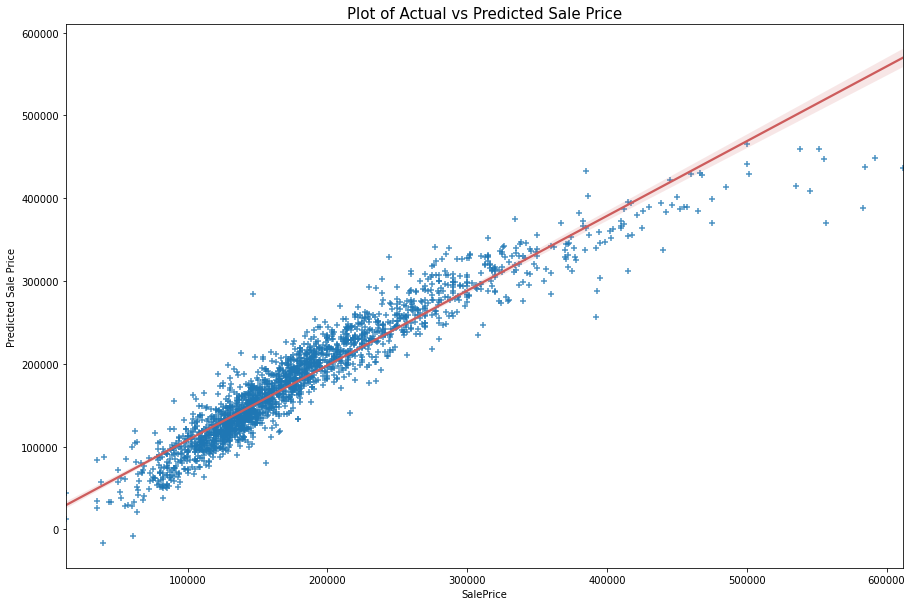

In [78]:
# Obtain predictions based on refined lasso model
pred_ref = lasso_ref.predict(Xss_ref)

# Plot predictions against actuals
plt.figure(figsize=(15,10))
plt.title("Plot of Actual vs Predicted Sale Price", size = 15)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
sns.regplot(x = y, y = pred_ref,marker='+',line_kws={'color':'indianred'});

### 4.4 Residuals for refined model <a class="anchor" id="section_4_4"></a>

The RMSE for the model is 24475.6238.


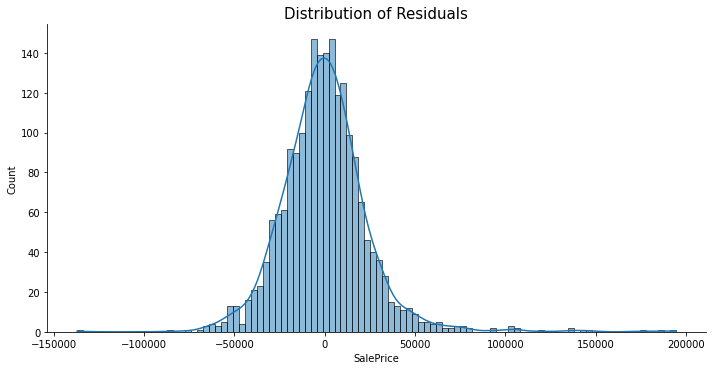

In [79]:
# Obtaining refined residuals
residuals_ref = y - pred_ref
RMSE_ref = np.sqrt(mean_squared_error(y,pred_ref))
print(f"The RMSE for the model is {round(RMSE_ref,4)}.")

# Plot distribution of residuals
sns.displot(x=residuals_ref,bins=100,kde=True,aspect=2)
plt.title("Distribution of Residuals",size=15);

### 4.5 Evaluation of results <a class="anchor" id="section_4_5"></a>

Summary of steps performed:
1. Fitted `LassoCV` with all parameters as defined in 'features'
2. Obtained the R2 and RMSE
3. Observed `LassoCV` coefficients and obtained list of parameters with coefficient = 0
4. Refined original features list by removing paramenters with coefficient = 0
5. Re-fitted `LassoCV` with new refined features
5. Obtained the R2 and RMSE for the new refined model

|Parameters Used|R2 Score|RMSE|
|:-:|:-:|:-:|
|Originial features|0.9008|24,970.5444|
|Refined features|0.9047|24,475.6238|

It is observed that both the R2 and RMSE for the refined features has improved, although the improvement is rather minor and insignificant.

## 5. Test Data Prediction <a class="anchor" id="chapter5"></a>
---

Based on the `LassoCV` model, predictions will be run on the test data set and file will be exported for Kaggle submission. 2 separate files will be created for the model with `original features` and `refined features` to compare the results.

### 5.1 Original features lasso model <a class="anchor" id="section_5_1"></a>

In [80]:
# Creating feature matrix
X_test = test_df[features]

# Scaling the feature matrix for use in LassoCV
ss.fit(X_test)
Xss_test = ss.transform(X_test)

# Use fitted lasso model to predict values for test data set
pred_test = lasso.predict(Xss_test)

# Export data for Kaggle submission
test_result = pd.DataFrame(data = {'Id':test_df['Id'],'SalePrice':pred_test})
test_result.to_csv("../datasets/test_results.csv",index=False)

### 5.2 Refined features lasso model <a class="anchor" id="section_5_2"></a>

In [81]:
# Creating feature matrix
Xref_test = test_df[features_ref]

# Scaling the feature matrix for use in LassoCV
ss.fit(Xref_test)
Xrefss_test = ss.transform(Xref_test)

# Use fitted lasso model to predict values for test data set
pred_ref_test = lasso_ref.predict(Xrefss_test)

# Export data for Kaggle submission
test_result_ref = pd.DataFrame(data = {'Id':test_df['Id'],'SalePrice':pred_ref_test})
test_result_ref.to_csv("../datasets/test_results_ref.csv",index=False)

### 5.3 Kaggle results <a class="anchor" id="section_5_3"></a>

#### Original Parameters

![original](../images/original_kaggle_results.png)

#### Refined Parameters

![refined](../images/refined_kaggle_results.png)

## 6. Conclusion <a class="anchor" id="chapter6"></a>
---

- Based on the cross validation results, `LassoCV` was the model that had the lower bias and variance
- Results of the model showed a RMSE of 24,971 with normally distributed residuals, indicating that the model generalises well and was the right model to be used
- Running the model on the Kaggle data set revealed a RMSE of 29,497, which is a successful outcome based on our Data Science problem statement
- Attempts to refine the model by removing parameters with `Lasso` coefficient of 0 proved to show no significant improvements
- Kaggle score from the refined model was 29,610, suggesting no difference from the initial instance of the model
- This could possible be due to the use of OneHotEncoder, which compared to GetDummies, does not create additional columns but instead turns each value within the column into an array
- Those parameters with 0 coefficient have already been effectively removed in the initial instance of the `Lasso` model, which is a possible reason why there were no improvements in the score
- Model could be retested using a GetDummies approach instead of OneHotEncoder in order to test if removing parameters with coefficient 0 after the first instance of the `Lasso` model could help improve the results

## 7. Limitations <a class="anchor" id="chapter7"></a>
---

### 7.1 Long term prediction <a class="anchor" id="section7_1"></a>
The model that has been built has shown to be rather accurate at predicting properties. However. this model runs on past data and is only as good as how recent the database is. While it may be quite accurate in terms of predicting the value of a property in the next 1 or 2 years, it will not be able to predict the potential value in a longer period of time (5 or more years) that would be more for investment purposes. 

### 7.2 Scope <a class="anchor" id="section7_2"></a>
The scope of this model is contained to prediction of properties that already have buildings/houses built due to the nature of the data. Therefore, when it comes to predicting the value of an area of land for example, the scope would be different and results would not be reliable.

### 7.3 Location score <a class="anchor" id="section7_3"></a>
The model relied on a engineered feature `neighborhood_score`, which assigned a ordinal value to the different neighborhoods based on the mean of that neighborhood's `built_in_ppsf`. While this may be a good past indicator in terms of value of a neighborhood value, it might not take into factor future developments. Therefore, increased development in infrastructure in retail & dining, healthcare, education that are important in determining the value of a neighborhood will not be factored in only until there are enough eventual sales in that neighborhood. Therefore, in the data collection process, it would be good to consider collection of data points such as proximity to positive public infrastructure to further refine predictions.